# Импорт библиотек

In [ ]:
import re
import bz2
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 695.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4de893f64b3defbb1cf4ed5ff319924612e419bfa32ad433bbce7b717eae4a06
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import Counter

import gensim
import pymorphy2
from string import punctuation
from gensim.corpora import Dictionary
from gensim.models import LdaModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Загрузка данных

In [ ]:
file_name = 'banki_responses.json.bz2'
responses = []

with bz2.BZ2File(file_name, 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:31, 1330.95it/s]


In [ ]:
df = pd.DataFrame.from_dict(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


# Часть 1. Анализ текстов

In [ ]:
# 1.1. Количество отзывов в разных городах

df['city'].str.lower().str.replace(r'г.', '').value_counts().reset_index()

,city,count
0,москва,56728
1,санкт-петербург,14650
2,новосибирск,2381
3,екатеринбург,2375
4,нижний новгород,2036
...,...,...
5130,"нижегородская обл., дзержинск",1
5131,"балахна, нижегородской области",1
5132,мытищи,1
5133,поселок горки-10,1


In [ ]:
# 1.2. Количество отзывов на разные банки

df['bank_name'].value_counts().reset_index()

,bank_name,count
0,Сбербанк России,26327
1,Альфа-Банк,10224
2,ВТБ 24,8185
3,Русский Стандарт,7943
4,Хоум Кредит Банк,7549
...,...,...
665,Сиббизнесбанк,1
666,Донбанк,1
667,Потенциал,1
668,Ури Банк,1


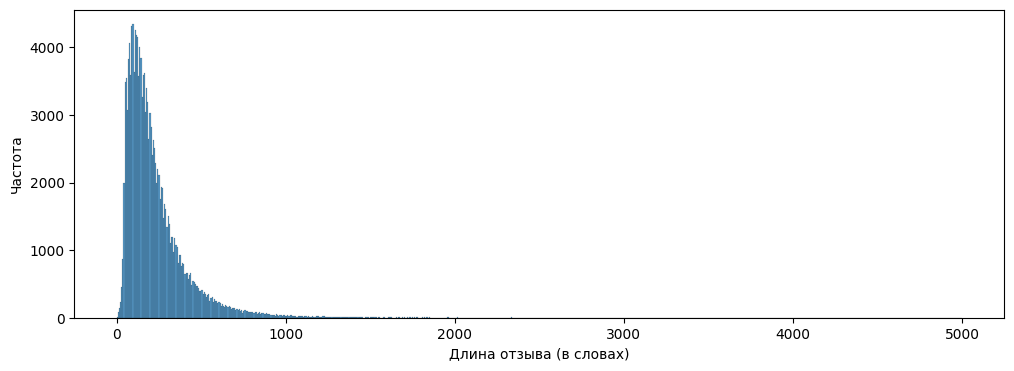

In [ ]:
# 2.1. Гистограмма длины отзывов в словах

df['text_clear'] = df['text'].str.replace(r'[^а-яА-Я]', ' ', regex=True)

plt.figure(figsize=(12, 4))
sns.histplot(df['text_clear'].str.split().str.len())
plt.xlabel('Длина отзыва (в словах)')
plt.ylabel('Частота')
plt.show()

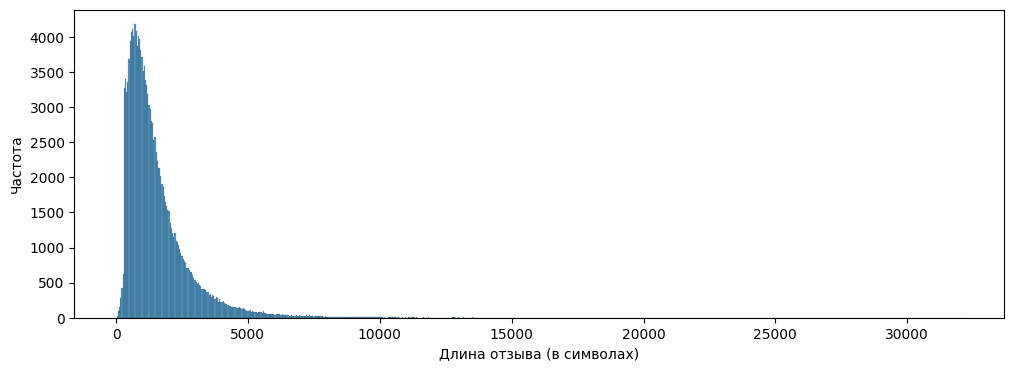

In [ ]:
# 2.2. Гистограмма длины отзывов в символах

plt.figure(figsize=(12, 4))
sns.histplot(df['text'].str.len())
plt.xlabel('Длина отзыва (в символах)')
plt.ylabel('Частота')
plt.show()

In [ ]:
# 3.1. 10 самых частых слов

all_texts = ' '.join([text for text in df.iloc[:10000]['text_clear']])
tokenized_texts = nltk.tokenize.word_tokenize(str.lower(all_texts))

freq_texts = FreqDist(tokenized_texts)
freq_texts.most_common(10)

[('в', 75571),
 ('и', 60839),
 ('не', 49877),
 ('на', 41273),
 ('что', 36343),
 ('я', 33614),
 ('с', 28536),
 ('по', 22747),
 ('мне', 19041),
 ('банка', 17330)]

In [ ]:
# 3.2. 10 самых частых слов без стоп-слов

russian_stopwords = stopwords.words("russian")

texts_without_stopwords = [word for word in tokenized_texts if word not in russian_stopwords]
texts_without_stopwords = [word for word in texts_without_stopwords if len(word) > 1]

freq_texts = FreqDist(texts_without_stopwords)
freq_texts.most_common(10)

[('банка', 17330),
 ('банк', 13989),
 ('это', 10138),
 ('деньги', 7068),
 ('карты', 6059),
 ('карту', 5677),
 ('день', 4742),
 ('кредит', 4663),
 ('банке', 4175),
 ('заявление', 3982)]

In [ ]:
# 3.3. 10 самых частых лемм

analyzer = pymorphy2.MorphAnalyzer()
lemmatized_texts = [analyzer.parse(word)[0].normal_form for word in texts_without_stopwords]

freq_texts = FreqDist(lemmatized_texts)
freq_texts.most_common(10)

[('банк', 41820),
 ('карта', 18950),
 ('это', 11057),
 ('мой', 10804),
 ('день', 10048),
 ('кредит', 9776),
 ('деньга', 9579),
 ('сотрудник', 9373),
 ('который', 9098),
 ('клиент', 7981)]

In [ ]:
# 3.4. 10 самых частых существительных

n = 10
tag = 'NOUN'

i = 0
for word in freq_texts:
  if analyzer.parse(word)[0].tag.POS == tag:
    print(f'{word}, {freq_texts[word]}')
    i += 1
  if i == 10: break

банк, 41820
карта, 18950
день, 10048
кредит, 9776
деньга, 9579
сотрудник, 9373
клиент, 7981
сумма, 6997
счёт, 6974
отделение, 6909


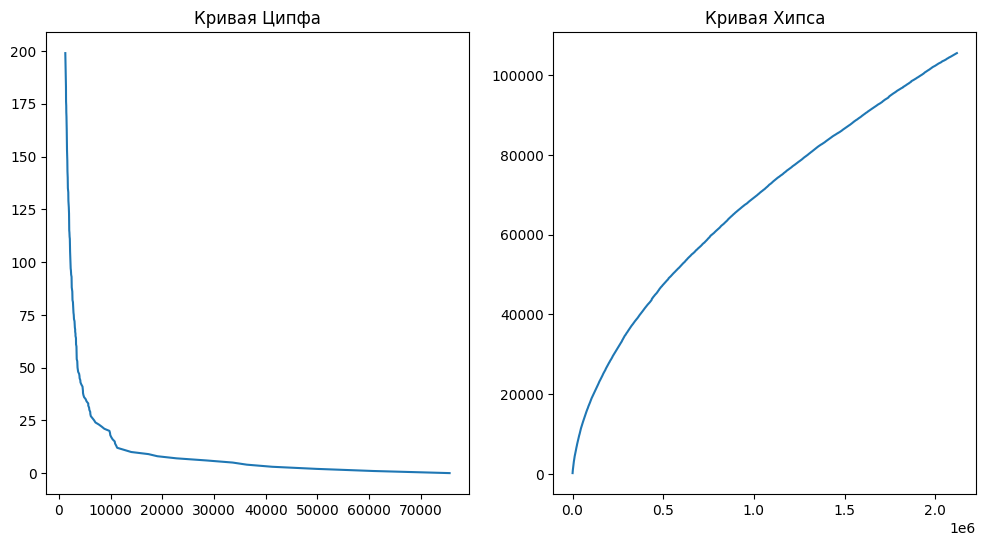

In [ ]:
# 4. Кривые Ципфа и Хипса

r = 200
texts_plt = ' '.join([text for text in df.iloc[:10000]['text']])
tokenized_texts_plt = nltk.tokenize.word_tokenize(str.lower(all_texts))
freq_texts_plt = FreqDist(tokenized_texts_plt)
freq_texts_plt = sorted(list(freq_texts_plt.values()), reverse = True)

n_words = []
n_tokens = []
cnt = Counter()
for i, row in df[:10000].iterrows():
  tokens = word_tokenize(row['text'])
  cnt.update([token for token in tokens if token not in punctuation])
  n_words.append(len(cnt))
  n_tokens.append(sum(cnt.values()))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(freq_texts_plt[:r], range(r))
ax[1].plot(n_tokens, n_words)
ax[0].set_title('Кривая Ципфа')
ax[1].set_title('Кривая Хипса')
plt.show()

In [ ]:
# 5.1. Какое слово встречается чаще, "сотрудник" или "клиент"?

word_1 = 'сотрудник'
word_2 = 'клиент'

if freq_texts[word_1] > freq_texts[word_2]:
  print(word_1)
elif freq_texts[word_1] < freq_texts[word_2]:
  print(word_2)
else:
  print(f'слова {word_1} и {word_2} встречаются одинаково часто')

сотрудник


In [ ]:
# 5.2. Сколько раз встречается слова "мошенничество" и "доверие"?

word_1 = 'мошенничество'
word_2 = 'доверие'

print(f'{word_1}, {freq_texts[word_1]}')
print(f'{word_2}, {freq_texts[word_2]}')

мошенничество, 221
доверие, 152


In [ ]:
# 6. Ключевые слова и биграмы для положительных и отрицательных отзывов

In [ ]:
def get_lemmatized_texts(df):

  analyzer = pymorphy2.MorphAnalyzer()
  russian_stopwords = stopwords.words("russian")

  df['text_lemmatized'] = df['text_clear'].str.lower()
  df['text_lemmatized'] = df['text_lemmatized'].apply(
      lambda x: ' '.join([word for word in x.split() if (
          word not in (russian_stopwords) and len(word) > 2)]))
  df['text_lemmatized'] = df['text_lemmatized'].apply(
      lambda x: ' '.join([analyzer.parse(word)[0].normal_form for word in x.split()]))

  return df

df_positive = df[df['rating_grade'] == 5][:10000]
df_negative = df[df['rating_grade'] == 1][:10000]

df_positive = get_lemmatized_texts(df_positive)
df_negative = get_lemmatized_texts(df_negative)

In [ ]:
def get_top_n(df, field_name, N, ngram_range=(1, 1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
  tfidf_vectorizer.fit_transform(df[field_name].to_list())
  feature_names = tfidf_vectorizer.get_feature_names_out()

  result = []
  for text in df[field_name]:
    result.append(get_keywords(text, tfidf_vectorizer, feature_names, N))

  df['top_n_keywords'] = result

  all_keywords = ''
  for i in df['top_n_keywords']:
    all_keywords += ', '.join(i)

  tokenized_keywords = all_keywords.split(', ')
  freq_keywords = FreqDist(tokenized_keywords)
  return ', '.join([word[0] for word in freq_keywords.most_common(10)])

def get_keywords(text, tfidf_vectorizer, feature_names, N=10):
  tf_idf_vector = tfidf_vectorizer.transform([text])
  sorted_items = sort_coo(tf_idf_vector.tocoo())
  keywords = extract_topn_from_vector(feature_names, sorted_items, N)

  return list(keywords.keys())

def sort_coo(coo_matrix):
  tuples = zip(coo_matrix.col, coo_matrix.data)

  return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, N=10):
  if len(sorted_items) < N:
    N = len(sorted_items)

  sorted_items = sorted_items[:N]
  score_vals = []
  feature_vals = []

  for idx, score in sorted_items:
    score_vals.append(round(score, 3))
    feature_vals.append(feature_names[idx])

  results= {}
  for idx in range(len(feature_vals)):
      results[feature_vals[idx]]=score_vals[idx]

  return results

In [ ]:
N = 10

print(f"Топ-{N} ключевых слов для положительных отзывов: {get_top_n(df_positive, 'text_lemmatized', N)}")
print(f"Топ-{N} биграмм для положительных отзывов: {get_top_n(df_positive, 'text_lemmatized', N, (2, 2))}")

Топ-10 ключевых слов для положительных отзывов: банк, карта, вклад, кредит, отделение, счёт, деньга, офис, документ, сделка
Топ-10 биграмм для положительных отзывов: интернет банк, хоум кредит, альфа банк, банк авангард, колл центр, кредитный карта, банк втб, ткс банк, банк русский, отделение банк


In [ ]:
print(f"Топ-{N} ключевых слов для отрицательных отзывов: {get_top_n(df_negative, 'text_lemmatized', N)}")
print(f"Топ-{N} биграмм для отрицательных отзывов: {get_top_n(df_negative, 'text_lemmatized', N, (2, 2))}")

Топ-10 ключевых слов для отрицательных отзывов: карта, банк, кредит, деньга, вклад, сбербанк, счёт, заявление, платёж, банкомат
Топ-10 биграмм для отрицательных отзывов: интернет банк, денежный средство, альфа банк, досрочный погашение, ваш банк, колл центр, кредитный карта, годовой обслуживание, пин код, мобильный банк


# Часть 2. Тематическое моделирование

In [ ]:
df = get_lemmatized_texts(df)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_clear,text_lemmatized
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Добрый день Я не являюсь клиентом банка и пор...,добрый день являться клиент банк поручитель кр...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Доброго дня Являюсь держателем зарплатной кар...,добрый день являться держатель зарплатный карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Здравствуйте Дублирую свое заявление от ...,здравствуйте дублировать свой заявление можайс...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,Добрый день Я открыл расчетный счет в СберБа...,добрый день открыть расчётный счёт сбербанк юр...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заяв...,взять кредит ваш банк заявить я сумма рубль го...


In [ ]:
texts = [text.split() for text in df['text_lemmatized']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# 1.1. Примеры понятных (интерпретируемых) тем:

In [ ]:
num_topics = [2, 5, 10]

for i in num_topics:
  print(f'\n  num_topics = {i}\n')
  lda_model = LdaModel(corpus, num_topics=i, id2word=dictionary, passes=10)
  for idx, topic in lda_model.print_topics(-1):
      print(f"Тема {idx + 1}: {topic}")


  num_topics = 2

Тема 1: 0.025*"банк" + 0.019*"карта" + 0.011*"это" + 0.010*"деньга" + 0.009*"отделение" + 0.007*"клиент" + 0.006*"день" + 0.006*"счёт" + 0.006*"который" + 0.006*"банкомат"
Тема 2: 0.036*"банк" + 0.023*"кредит" + 0.010*"день" + 0.010*"мой" + 0.009*"сумма" + 0.008*"кредитный" + 0.008*"договор" + 0.008*"документ" + 0.008*"это" + 0.007*"который"

  num_topics = 5

Тема 1: 0.015*"банк" + 0.014*"отделение" + 0.011*"это" + 0.008*"сказать" + 0.008*"работать" + 0.008*"клиент" + 0.008*"офис" + 0.008*"очередь" + 0.008*"день" + 0.007*"сотрудник"
Тема 2: 0.041*"банк" + 0.015*"мой" + 0.013*"договор" + 0.012*"счёт" + 0.011*"сотрудник" + 0.010*"заявление" + 0.009*"ответ" + 0.009*"клиент" + 0.009*"документ" + 0.009*"который"
Тема 3: 0.048*"кредит" + 0.039*"банк" + 0.014*"сумма" + 0.014*"кредитный" + 0.013*"платёж" + 0.011*"это" + 0.010*"день" + 0.010*"месяц" + 0.010*"год" + 0.008*"звонить"
Тема 4: 0.052*"карта" + 0.024*"деньга" + 0.020*"банк" + 0.017*"банкомат" + 0.015*"счёт" + 0.013

В целом, из полученных вариантов можно составить полноценные темы, изменив немного слова. Варианты, конечно, немого неказистые, но вполне похожи на реальные проблемы.

На первый взгляд увеличение значения num_topics пораждает более осмысленные варианты тем.

In [ ]:
#   num_topics = 2

# Тема 1:  снятие денег с карты в банкомате или со счета клиента в отделении банка
# Тема 2:  сумма моего кредита в банке, которая указана в кредитном договоре

#   num_topics = 5

# Тема 1:  подскажите, большая ли очередь к сотрудникам отделения банка по работе с клиентами
# Тема 2:  сотрудник в банке, который ответил на мое заявление о клиентсвом счете
# Тема 3:  в этот же день не перезвонили для уточнения суммы кредитного платежа в месяц для кредита на 1 год
# Тема 4:  заявление на снятие с карты в банкомате или со счета в отделении банка в один день
# Тема 5:  это банк, у которого очень плохое годовое обсуживание клиентов по вкладам, картам и счетам

#   num_topics = 10

# Тема 1:  заявление на сумма средств, снятых за день в банкомате с моего банковского счета
# Тема 2:  договор с банком - это документ, который дает право использовать мой клиентский счет как физ.лицо в рф
# Тема 3:  заявление на получение годового обслуживания моей кредитной карты в банке с указанием лимитов
# Тема 4:  номер телефона поддержки по услугам банковской системы на сайте интернет-оператора
# Тема 5:  как получить у менеджера все документы для заявки на кредит в банке (анкеты и кредитные справки)
# Тема 6:  как успеть открыть вклад в отделении банка, если сотрудник за 50 минут успевает отработать только с одним клиентом на кассе
# Тема 7:  как изменится сумма платежа за год при задолженности за текущий месяц и последующем досрочном погашении за следующий
# Тема 8:  клиент этого банка уже готорый год испытывает такие проблемы со своим счетом
# Тема 9:  девушка уже который день звонит и говорит, что я могу взять деньги в отделении этого банка
# Тема 10: сотрудник банка звонит по моему номеру телефона и педлагает стать вашим клиентом

In [ ]:
# 1.2. Темы, в которых упомянуты конкретные банки

In [ ]:
lda_model = LdaModel(corpus, num_topics=20, id2word=dictionary, passes=10)
for idx, topic in lda_model.print_topics(-1):
  print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.045*"банк" + 0.024*"мой" + 0.023*"заявление" + 0.017*"сотрудник" + 0.015*"ответ" + 0.013*"средство" + 0.012*"претензия" + 0.012*"который" + 0.012*"клиент" + 0.010*"получить"
Тема 2: 0.072*"письмо" + 0.061*"почта" + 0.035*"служба" + 0.030*"ответ" + 0.025*"электронный" + 0.025*"поддержка" + 0.022*"отправить" + 0.022*"адрес" + 0.016*"получить" + 0.016*"выписка"
Тема 3: 0.076*"договор" + 0.059*"кредит" + 0.031*"банк" + 0.020*"страховка" + 0.017*"условие" + 0.013*"сумма" + 0.012*"страховой" + 0.011*"страхование" + 0.011*"подписать" + 0.010*"кредитный"
Тема 4: 0.053*"карта" + 0.032*"банк" + 0.017*"комиссия" + 0.015*"лимит" + 0.012*"кредитный" + 0.012*"интернет" + 0.012*"рубль" + 0.010*"тариф" + 0.010*"обслуживание" + 0.010*"сумма"
Тема 5: 0.016*"тот" + 0.015*"система" + 0.015*"сч" + 0.015*"вс" + 0.014*"проблема" + 0.014*"это" + 0.011*"интернет" + 0.011*"втб" + 0.010*"который" + 0.009*"ещ"
Тема 6: 0.079*"деньга" + 0.078*"банкомат" + 0.020*"день" + 0.018*"карта" + 0.017*"сумма" + 0.0

In [ ]:
# Тема 5: "втб"
# Тема 7: "альфа"
# Тема 8: "русский стандарт"
# Тема 12: "сбербанк"
# Тема 14: "открытие"
# Тема 19: "траст"

В 6 из 20 тем упомянуты разные наименования конкретных банков.

В случае 2, 5 или 10 тем наименования конкретных банков не появлялись в предложенных моделью темах. Возможно это связано с тем, что с увеличением значения num_topics происходит более глубокое изучение отзывов для выявления из них указанного количества тем.

То есть, в данном случае при num_topics = 20 темы начинают делиться не только по категориям обращения (например, кредит, счет, вклад и тд), но и по конкретным банкам.

# Часть 3. Классификация отзывов на отрицательные положительные

In [ ]:
# 1. Подготовка данных

In [ ]:
df_class = df[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_class['text_lemmatized'],
                                                    df_class['rating_grade'],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# 2. Классификация (RandomForestClassifier)

In [ ]:
def get_class_report(X_train, X_test, y_train, y_test, ngram_range=(1, 1)):
  vec = CountVectorizer(ngram_range=ngram_range)
  bow = vec.fit_transform(X_train)

  clf = RandomForestClassifier(random_state=42)
  clf.fit(bow, y_train)

  y_pred = clf.predict(vec.transform(X_test))
  print(f'ngram_range = {ngram_range}\n\n{classification_report(y_pred, y_test)}')

In [ ]:
n_ngram = [1, 2, 3]

for n in n_ngram:
  get_class_report(X_train, X_test, y_train, y_test, (n, n))

ngram_range = (1, 1)

              precision    recall  f1-score   support

         1.0       1.00      0.89      0.94     10626
         5.0       0.60      0.99      0.75      1794

    accuracy                           0.90     12420
   macro avg       0.80      0.94      0.84     12420
weighted avg       0.94      0.90      0.91     12420

ngram_range = (2, 2)

              precision    recall  f1-score   support

         1.0       0.99      0.90      0.94     10467
         5.0       0.64      0.96      0.77      1953

    accuracy                           0.91     12420
   macro avg       0.82      0.93      0.85     12420
weighted avg       0.94      0.91      0.92     12420

ngram_range = (3, 3)

              precision    recall  f1-score   support

         1.0       0.99      0.84      0.91     11089
         5.0       0.41      0.91      0.57      1331

    accuracy                           0.85     12420
   macro avg       0.70      0.88      0.74     12420
weighted

In [ ]:
# 3. Классификация с использованием скрытых тем

In [ ]:
def get_class_report_theme(X_train, X_test, y_train, y_test, ngram_range=(1, 1)):

  clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=ngram_range)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('tm', TruncatedSVD(n_components=15, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
  ])

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  print(f'ngram_range = {ngram_range}\n\n{classification_report(y_pred, y_test)}')

In [ ]:
n_ngram = [1, 2, 3]

for n in n_ngram:
  get_class_report_theme(X_train, X_test, y_train, y_test, (n, n))

ngram_range = (1, 1)

              precision    recall  f1-score   support

         1.0       0.98      0.93      0.95      9998
         5.0       0.76      0.93      0.84      2422

    accuracy                           0.93     12420
   macro avg       0.87      0.93      0.90     12420
weighted avg       0.94      0.93      0.93     12420

ngram_range = (2, 2)

              precision    recall  f1-score   support

         1.0       0.97      0.90      0.93     10268
         5.0       0.63      0.87      0.73      2152

    accuracy                           0.89     12420
   macro avg       0.80      0.88      0.83     12420
weighted avg       0.91      0.89      0.90     12420

ngram_range = (3, 3)

              precision    recall  f1-score   support

         1.0       0.94      0.86      0.90     10400
         5.0       0.51      0.74      0.60      2020

    accuracy                           0.84     12420
   macro avg       0.73      0.80      0.75     12420
weighted

В случае униграмм метрики f1-score и accuracy стали лучше, f1-score для положительных и отрицательных отзывов уже не так сильно отличаются.

Для биграммы и триграммы ситуация в любом случае не очень хорошая для рейтинга 5.0.

In [ ]:
# 4. Другая модель классификации (LogisticRegression)

In [ ]:
def get_class_report_lr(X_train, X_test, y_train, y_test, ngram_range=(1, 1)):
  vec = CountVectorizer(ngram_range=ngram_range)
  bow = vec.fit_transform(X_train)

  clf = LogisticRegression(random_state=42, solver='liblinear')
  clf.fit(bow, y_train)

  y_pred = clf.predict(vec.transform(X_test))
  print(f'ngram_range = {ngram_range}\n\n{classification_report(y_pred, y_test)}')

def get_class_report_theme_lr(X_train, X_test, y_train, y_test, ngram_range=(1, 1)):

  clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=ngram_range)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('tm', TruncatedSVD(n_components=15, random_state=42)),
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
  ])

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  print(f'ngram_range = {ngram_range}\n\n{classification_report(y_pred, y_test)}')

In [ ]:
n_ngram = [1, 2, 3]

for n in n_ngram:
  get_class_report_lr(X_train, X_test, y_train, y_test, (n, n))

ngram_range = (1, 1)

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97      9517
         5.0       0.91      0.92      0.92      2903

    accuracy                           0.96     12420
   macro avg       0.94      0.95      0.94     12420
weighted avg       0.96      0.96      0.96     12420

ngram_range = (2, 2)

              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97      9867
         5.0       0.83      0.95      0.89      2553

    accuracy                           0.95     12420
   macro avg       0.91      0.95      0.93     12420
weighted avg       0.95      0.95      0.95     12420

ngram_range = (3, 3)

              precision    recall  f1-score   support

         1.0       1.00      0.83      0.91     11297
         5.0       0.37      0.96      0.53      1123

    accuracy                           0.85     12420
   macro avg       0.68      0.90      0.72     12420
weighted

In [ ]:
n_ngram = [1, 2, 3]

for n in n_ngram:
  get_class_report_theme_lr(X_train, X_test, y_train, y_test, (n, n))

ngram_range = (1, 1)

              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96      9847
         5.0       0.80      0.92      0.85      2573

    accuracy                           0.93     12420
   macro avg       0.89      0.93      0.91     12420
weighted avg       0.94      0.93      0.94     12420

ngram_range = (2, 2)

              precision    recall  f1-score   support

         1.0       0.98      0.85      0.91     10929
         5.0       0.45      0.89      0.60      1491

    accuracy                           0.86     12420
   macro avg       0.72      0.87      0.75     12420
weighted avg       0.92      0.86      0.87     12420

ngram_range = (3, 3)

              precision    recall  f1-score   support

         1.0       1.00      0.77      0.87     12288
         5.0       0.04      0.83      0.07       132

    accuracy                           0.77     12420
   macro avg       0.52      0.80      0.47     12420
weighted

Для логистической регрессии вариант без использования скрытых тем оказался лучше.

Метрики f1-score и accuracy для униграмм и биграмм здесь выше чем у модель случайного леса.